In [1]:
from discrimenator import Discriminator
from Generator import Generator
import Config
from datasetLoading import CustomData
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch
from torchvision.utils import save_image
from torchvision import transforms
import warnings
import numpy as np
from torch import nn
from torchvision import models
from VisionTransformer import VisionTransformer
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Use this model if you dont want to use pre-train weights (This is a simple vgg)
def make_model(pretrained=False):
    model_ft = models.vgg16(pretrained=False)
    model_ft.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    model_ft.features = model_ft.features[:17]
    model_ft.classifier[0] = nn.Linear(in_features=256 * 7*7 , out_features=4096, bias=True)
    model_ft.classifier[6] = nn.Linear(in_features=4096, out_features=4, bias=True)
    return model_ft

In [ ]:
# Run this cell for training model 
class_name = ['CNV', 'DME', 'DRUSEN', 'NORMAL']
def train_fn(NoiseDisc ,HealtyDisc , HealtyGen , NoiseGen , loader , opt_disc , opt_gen , l1 , mse , CE , d_scaler , g_scaler , epoch , clf = None , clf_opt=None ,c_scaler=None, use_clf=False) :
    
    loop = tqdm(loader , leave=True)
    # loop through data
    # Create empty results dictionary
    results = {"Loss on ICIP data" :[],
                "Loss on DK data"  : [],
                "loss_DK" : [],
                "loss_ICIP" : [],
                "cycle_DK_Data_loss": [],
                "cycle_ICIP_Data_loss": [],
                "identity_ICIP_Data_loss" : [],
                "identity_DK_Data_loss" :[]
    }
    for idx , (HealtyData ,NoisyData , Name_Healthy , Name_Noisy) in enumerate(loop):
        HealtyData = HealtyData.to(Config.DEVICE)
        NoisyData = NoisyData.to(Config.DEVICE)
        # print(HealtyData.shape , NoisyData.shape)
        # Train Discriminator 
        with torch.cuda.amp.autocast():
            # generate fake NoisyData from HealtyData
            fake_NoisyData = NoiseGen(HealtyData)
            D_Noise_real = NoiseDisc(NoisyData)
            D_Noise_fake = NoiseDisc(fake_NoisyData.detach())
            D_Noise_real_loss = mse(D_Noise_real , torch.ones_like(D_Noise_real))
            D_Noise_fake_loss = mse(D_Noise_fake , torch.zeros_like(D_Noise_fake))
            D_Noise_loss = D_Noise_real_loss + D_Noise_fake_loss
            # generate fake HealtyData from NoisyData
            fake_HealtyData = HealtyGen(NoisyData)
            D_Healty_real = HealtyDisc(HealtyData)
            D_Healty_fake = HealtyDisc(fake_HealtyData.detach())
            D_Healty_real_loss = mse(D_Healty_real , torch.ones_like(D_Healty_real))
            D_Healty_fake_loss = mse(D_Healty_fake , torch.zeros_like(D_Healty_fake))
            D_Healty_loss = D_Healty_real_loss + D_Healty_fake_loss
            # put it together
            D_loss = (D_Noise_loss + D_Healty_loss) / 2

        opt_disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()
        # Train Generator H and Z
        with torch.cuda.amp.autocast():
            # adversial loss for both generator
            D_Noise_fake = NoiseDisc(fake_NoisyData)
            D_Healty_fake = HealtyDisc(fake_HealtyData)
            loss_Gen_Noise = mse(D_Noise_fake , torch.ones_like(D_Noise_fake))
            loss_Gen_Healty = mse(D_Healty_fake , torch.ones_like(D_Healty_fake))
            # cycle loss
            cycle_HealtyData = HealtyGen(fake_NoisyData)
            cycle_NoisyData = NoiseGen(fake_HealtyData)
            cycle_HealtyData_loss = l1(HealtyData ,cycle_HealtyData)
            cycle_NoisyData_loss = l1(NoisyData, cycle_NoisyData)
            # identity loss
            identity_HealtyData = HealtyGen(HealtyData)
            identity_NoisyData = NoiseGen(NoisyData)
            identity_HealtyData_loss = l1(HealtyData , identity_HealtyData)
            identity_NoisyData_loss = l1(NoisyData , identity_NoisyData)
            if use_clf :
                # Find the index for dk
                Healthy_label = [name.split("-")[0] for name in Name_Healthy]
                Healthy_index = torch.Tensor([class_name.index(label) for label in Healthy_label]).to(Config.DEVICE)
                
                with torch.no_grad():
                    # (1)
                    # Find the clf label for fake Dk Data
                    fake_Healthy_logit = clf(fake_HealtyData)
                    # Find the clf label for cycle ICIP Data
                    cycle_Noisy_logit = clf(cycle_NoisyData)
                    # Define softmax for finding probabilities
                    softmax = torch.nn.Softmax(dim=1)
                    # Find the loss
                    loss_class_1 = l1(softmax(fake_Healthy_logit) , softmax(cycle_Noisy_logit))
                    # (2)
                    # Find the label for fake ICIP data
                    fake_noisy_logit = clf(fake_NoisyData)
                    # Find the loss for gen
                    Healthy_logit = clf(cycle_HealtyData)
                    loss_class_2 = l1(softmax(fake_noisy_logit),softmax(Healthy_logit))
                    loss_clf_gen = loss_class_1 + loss_class_2
                # adding all togther
                G_loss = (
                    loss_Gen_Healty +
                    loss_Gen_Noise + 
                    cycle_HealtyData_loss * Config.LAMBDA_CYCLE +
                    cycle_NoisyData_loss * Config.LAMBDA_CYCLE +
                    identity_NoisyData_loss * Config.LAMBDA_IDENTITY +
                    identity_HealtyData_loss * Config.LAMBDA_IDENTITY +
                    loss_clf_gen * Config.LAMBDA_CLF
                )
            
                
            else:
                # adding all togther
                G_loss = (
                    loss_Gen_Healty +
                    loss_Gen_Noise + 
                    cycle_HealtyData_loss * Config.LAMBDA_CYCLE +
                    cycle_NoisyData_loss * Config.LAMBDA_CYCLE +
                    identity_NoisyData_loss * Config.LAMBDA_IDENTITY +
                    identity_HealtyData_loss * Config.LAMBDA_IDENTITY
                )
            
                
                
        # train gen   
        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()
        # Train clf
        if use_clf : 
            # (3)
            # Train clf
            # Find the label for DK data
            Healthy_logit = clf(HealtyData)
            loss_clf_1 = CE(Healthy_logit , Healthy_index.to(dtype=torch.long))
            clf_opt.zero_grad()
            c_scaler.scale(loss_clf_1).backward()
            c_scaler.step(clf_opt)
            c_scaler.update()
            
            fake_noisy_logit = clf(fake_NoisyData.detach().to(dtype = torch.float))
            loss_clf_2 = CE(fake_noisy_logit , Healthy_index.to(dtype=torch.long))
            clf_opt.zero_grad()
            c_scaler.scale(loss_clf_2).backward()
            c_scaler.step(clf_opt)
            c_scaler.update()
            
        if idx % 400 == 0 :
            print("_____________________________________"*2)
            print(f"Epoch : {epoch}")
            print(f"Discriminator Loss :\nLoss on ICIP data: {D_Noise_loss}\nLoss on DK data {D_loss} ")
            print(f"classifier Loss:\nLoss on DK_data: {loss_clf_1}\nLoss on fake_ICIP_data: {loss_clf_2}\nGenerators clf loss : {loss_clf_gen}")
            print(f"Generator Loss :\nloss_DK : {loss_Gen_Healty}\nloss_ICIP : {loss_Gen_Noise}\ncycle_DK_Data_loss: {cycle_HealtyData_loss}\ncycle_ICIP_Data_loss: {cycle_NoisyData_loss}\nidentity_ICIP_Data_loss : {identity_NoisyData_loss}\nidentity_DK_Data_loss : {identity_HealtyData_loss}")
            Name_Healthy = str(Name_Healthy).replace(".jpeg","")
            Name_Noisy = str(Name_Noisy).replace(".tiff.png","")
            if(Config.BATCH_SIZE == 1):
                save_image(torch.stack([Un_Normalize(HealtyData),Un_Normalize(fake_NoisyData)]).squeeze(dim=1), Config.OUTPUT_PATH + f"{epoch}_{Name_Healthy}_Dk_to_ICIP_{idx}.png")
                save_image(torch.stack([Un_Normalize(NoisyData),Un_Normalize(fake_HealtyData)]).squeeze(dim=1), Config.OUTPUT_PATH + f"{epoch}_{Name_Noisy}_ICIP_to_Dk_{idx}.png")
                save_image(torch.stack([Un_Normalize(HealtyData),Un_Normalize(fake_NoisyData)]).squeeze(dim=1), Config.OUTPUT_PATH + f"{epoch}_{Name_Healthy}_Dk_to_ICIP_{idx}.png")
                save_image(torch.stack([Un_Normalize(HealtyData),Un_Normalize(cycle_HealtyData)]).squeeze(dim=1), Config.OUTPUT_PATH + f"{epoch}_{Name_Noisy}_cycle_DK_{idx}.png")
            else:
                save_image(torch.stack([Un_Normalize(HealtyData),Un_Normalize(fake_NoisyData)]).flatten(0,1), Config.OUTPUT_PATH + f"{epoch}_{idx}_{Name_Healthy}_Dk_to_ICIP.png")
                save_image(torch.stack([Un_Normalize(NoisyData),Un_Normalize(fake_HealtyData)]).flatten(0,1), Config.OUTPUT_PATH + f"{epoch}_{idx}_{Name_Noisy}_ICIP_to_Dk.png")
                save_image(torch.stack([Un_Normalize(NoisyData),Un_Normalize(cycle_NoisyData)]).flatten(0,1), Config.OUTPUT_PATH + f"{epoch}_{idx}_{Name_Noisy}_cycle_ICIP.png")
                save_image(torch.stack([Un_Normalize(HealtyData),Un_Normalize(cycle_HealtyData)]).flatten(0,1), Config.OUTPUT_PATH + f"{epoch}_{idx}_{Name_Healthy}_cycle_DK.png")
            results["Loss on ICIP data"].append(D_Noise_loss)
            results["Loss on DK data"].append(D_Noise_loss)
            results["loss_DK"].append(D_Noise_loss)
            results["loss_ICIP"].append(D_Noise_loss)
            results["cycle_DK_Data_loss"].append(D_Noise_loss)
            results["cycle_ICIP_Data_loss"].append(D_Noise_loss)
            results["identity_ICIP_Data_loss"].append(D_Noise_loss)
            results["identity_DK_Data_loss"].append(D_Noise_loss)
            np.save(f"./output/{idx}_loss" , results)

            
def Un_Normalize(image):   
    return image * 0.5 + 0.5
def main(use_clf ,use_compile):
    torch.set_float32_matmul_precision('high') if use_compile else None
    # Define discriminators
    disc_H = torch.compile(Discriminator(in_channels=1).to(Config.DEVICE)) if use_compile else  Discriminator(in_channels=1).to(Config.DEVICE)
    disc_Z = torch.compile(Discriminator(in_channels=1).to(Config.DEVICE)) if use_compile else  Discriminator(in_channels=1).to(Config.DEVICE)
    # Define Generators
    gen_Z = torch.compile(Generator(img_channels=1 , num_residuals=9).to(Config.DEVICE)) if use_compile else  Generator(img_channels=1 , num_residuals=9).to(Config.DEVICE)
    gen_H = torch.compile(Generator(img_channels=1 , num_residuals=9).to(Config.DEVICE)) if use_compile else Generator(img_channels=1 , num_residuals=9).to(Config.DEVICE)
    # Define clf
    if use_clf:
        # clf = make_model()
        # clf = torch.compile(clf.to(Config.DEVICE)) if use_compile else  clf.to(Config.DEVICE)
        clf = VisionTransformer(embed_dim = 256 , 
                            hidden_dim = 512,
                            n_feature=8 ,
                            num_channels = 3, 
                            num_heads = NUM_H , 
                            num_layers = NUM_TR ,
                            num_classes=4,
                            patch_size=PATCH_SIZE[0] ,
                            num_patches=NUM_PATCH , 
                            dropout=0.1 ).to(Config.DEVICE)
        torch.set_float32_matmul_precision('high')
        clf = torch.compile(clf)
        
        clf.load_state_dict(torch.load(Config.CLF_PATH))
        clf = clf.to(Config.DEVICE)
        
    else:
        clf = None
    # Define clf discriminarot
    if use_clf:
        clf_opt = torch.optim.AdamW(
        clf.parameters(),
        lr = Config.LEARNING_RATE,
    )
    else:
        clf_opt = None
    # Define Discriminator Optimizer
    opt_disc = torch.optim.AdamW(
        list(disc_H.parameters()) + list(disc_Z.parameters()),
        lr = Config.LEARNING_RATE,
    )
    # Define Generator Optimizer
    opt_gen = torch.optim.AdamW(
        list(gen_Z.parameters()) + list(gen_H.parameters()),
        lr = Config.LEARNING_RATE,
        betas = (0.5 , 0.999)
    )
    L1 = torch.nn.L1Loss()
    MSE = torch.nn.MSELoss()
    CE = torch.nn.CrossEntropyLoss()
    dataset = CustomData(root_data1 = Config.TRAIN_DIR_DATA1 
                         , root_data2 = Config.TRAIN_DIR_DATA2 
                         , transforms = Config.train_transform)
    # Define dataloader
    loader = DataLoader(
        dataset , 
        batch_size = Config.BATCH_SIZE , 
        shuffle=True , 
        num_workers = Config.NUM_WORKERS,
        pin_memory = True 
    )
    g_scaler = torch.cuda.amp.GradScaler()
    d_scaler = torch.cuda.amp.GradScaler()
    if use_clf : 
        c_scaler = torch.cuda.amp.GradScaler()
    else:
        use_clf = None

    if Config.LOAD_MODEL:
        PATH = Config.PRE_TRAIN_WEIGHTS
        disc_H.load_state_dict(torch.load(PATH + "DISC_H"))
        disc_Z.load_state_dict(torch.load(PATH + "DISC_Z"))
        gen_Z.load_state_dict(torch.load(PATH + "GEN_Z"))
        gen_H.load_state_dict(torch.load(PATH + "GEN_H"))
        opt_disc.load_state_dict(torch.load(PATH + "OPT_DISC"))
        opt_gen.load_state_dict(torch.load(PATH + "OPT_GEN"))
        if use_clf:
            clf.load_state_dict(torch.load(PATH + "Classifier"))
            clf_opt.load_state_dict(torch.load(PATH + "OPT_clf"))
            
    for epoch in range(Config.NUM_EPOCHS) : 
        train_fn(disc_H , disc_Z , gen_Z , gen_H , loader , opt_disc , opt_gen , L1 , MSE ,CE , d_scaler , g_scaler , epoch ,clf = clf , clf_opt=clf_opt ,c_scaler=c_scaler, use_clf=use_clf)
        if Config.SAVE_MODEL: 
            PATH = Config.SAVE_PATH + str(epoch) + "_"
            # Save discriminator noisy data
            torch.save(disc_H.state_dict() , PATH + "DISC_H") 
            # Save discriminator Healthy data
            torch.save(disc_Z.state_dict() , PATH + "DISC_Z") 
            # Save generator Healthy data
            torch.save(gen_Z.state_dict() , PATH + "GEN_Z") 
            # Save generator Noisy data
            torch.save(gen_H.state_dict() , PATH + "GEN_H")
            # Save Optmizer Discriminators
            torch.save(opt_disc.state_dict() , PATH + "OPT_DISC") 
            # Save Optimizers Generator
            torch.save(opt_gen.state_dict() , PATH + "OPT_GEN")
            if use_clf:
                 # Save Clf
                torch.save(clf.state_dict() , PATH + "Classifier") 
                # Save Optimizers Clf
                torch.save(clf_opt.state_dict() , PATH + "OPT_clf")
    
        
    return disc_H , disc_Z , gen_Z , gen_H , loader , opt_disc , opt_gen , L1 , MSE , d_scaler , g_scaler


disc_H , disc_Z , gen_Z , gen_H , loader , opt_disc , opt_gen , L1 , MSE , d_scaler , g_scaler = main(use_clf=Config.USE_CLF , use_compile=Config.USE_COMPILE)





  0%|                                                                          | 1/8755 [00:24<58:42:48, 24.15s/it]

__________________________________________________________________________
Epoch : 0
Discriminator Loss :
Loss on ICIP data: 0.5327386856079102
Loss on DK data 0.5235353112220764 
classifier Loss:
Loss on DK_data: 3.5970618724823
Loss on fake_ICIP_data: 2.404627799987793
Generators clf loss : 0.1117546558380127
Generator Loss :
loss_DK : 0.4089929163455963
loss_ICIP : 0.41917943954467773
cycle_DK_Data_loss: 0.8876609802246094
cycle_ICIP_Data_loss: 0.6739670038223267
identity_ICIP_Data_loss : 0.6630221605300903
identity_DK_Data_loss : 0.8836491107940674


  2%|█▊                                                                       | 218/8755 [01:56<1:01:46,  2.30it/s]

In [ ]:
Config.DEVICE

In [5]:
import torchvision.transforms as transforms
import torch
t = torch.tensor([[[1,2],[3,4]]] , dtype = torch.float32) 
print(t.shape)
o = transforms.Normalize(std = [0.5] , mean=[0.5])(t)
print(o)

torch.Size([1, 2, 2])
tensor([[[1., 3.],
         [5., 7.]]])


In [ ]:
torch.stack([t,t],dim=0) , torch.stack([t,t],dim=-1).shape

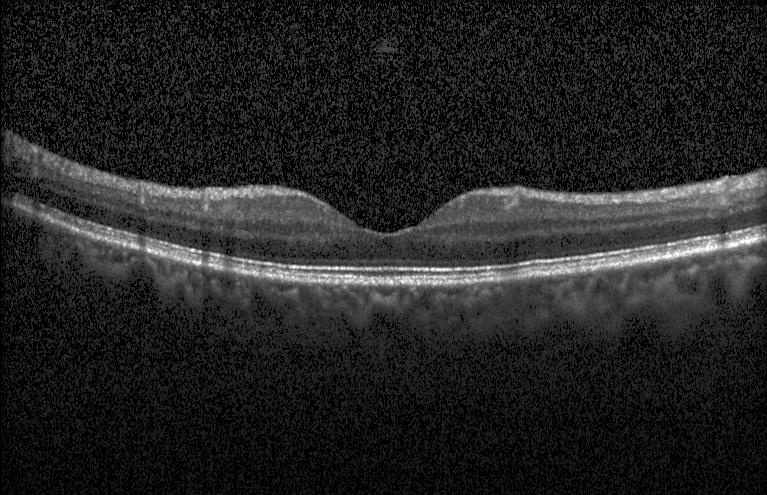

In [46]:
from PIL import Image
import Config
Dnoise = Image.open("./data/data1/NORMAL-653325-1.jpeg")
Dnoise

In [47]:
Config.train_transform

Compose(
    ToTensor()
    Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=warn)
)

0.0 0.9886171 torch.Size([3, 128, 128])


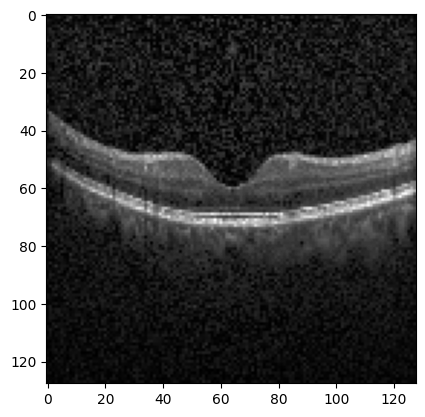

In [48]:
Dnoise = Config.train_transform(Dnoise)
import numpy as np
numpy_D = np.array(Dnoise)
print(numpy_D.min() , numpy_D.max(),Dnoise.shape)
import matplotlib.pyplot as plt
plt.imshow(np.moveaxis(numpy_D,0,2)[:,:,0] ,cmap="gray")

In [ ]:
n = np.array()

In [44]:
n = np.moveaxis(numpy_D,0,2)[:,:,0]
numpy_D.resize_(1,numpy_D.shape[1],numpy_D.shape[2]).shape

AttributeError: 'numpy.ndarray' object has no attribute 'resize_'

In [2]:
import numpy as np
np.array(Dnoise).min() , np.array(Dnoise).max()

(0, 255)

In [17]:
Dnoise = np.array(Dnoise) / 255.0

In [18]:
tensor = Config.train_transform(image = Dnoise)["image"]
tensor*0.5 + 0.5 , tensor.shape

(tensor([[[6.5118e-05, 3.4174e-04, 1.4669e-04,  ..., 1.6588e-04,
           1.7667e-04, 1.0961e-04],
          [8.9347e-05, 3.2899e-04, 1.4314e-04,  ..., 2.1452e-04,
           2.5243e-04, 1.2904e-04],
          [1.5372e-04, 3.7879e-04, 2.3514e-04,  ..., 3.2142e-04,
           3.4252e-04, 2.2039e-04],
          ...,
          [8.7053e-05, 5.1260e-06, 1.4350e-04,  ..., 1.1173e-04,
           2.0385e-05, 7.6890e-05],
          [5.8293e-05, 3.6865e-05, 1.3220e-04,  ..., 1.2213e-04,
           5.9605e-08, 5.2273e-05],
          [9.1076e-05, 3.7104e-05, 2.1636e-05,  ..., 9.1165e-05,
           2.0862e-07, 2.2501e-05]],
 
         [[5.0830e-01, 5.4358e-01, 5.1871e-01,  ..., 5.2115e-01,
           5.2253e-01, 5.1398e-01],
          [5.1139e-01, 5.4195e-01, 5.1825e-01,  ..., 5.2736e-01,
           5.3219e-01, 5.1646e-01],
          [5.1960e-01, 5.4830e-01, 5.2998e-01,  ..., 5.4098e-01,
           5.4367e-01, 5.2810e-01],
          ...,
          [5.1111e-01, 5.0065e-01, 5.1830e-01,  ..., 5.142

In [19]:
tensor.min() , tensor.max()

(tensor(-1.), tensor(0.9954))

In [20]:
tensor = tensor *0.5 + 0.5
tensor

tensor([[[6.5118e-05, 3.4174e-04, 1.4669e-04,  ..., 1.6588e-04,
          1.7667e-04, 1.0961e-04],
         [8.9347e-05, 3.2899e-04, 1.4314e-04,  ..., 2.1452e-04,
          2.5243e-04, 1.2904e-04],
         [1.5372e-04, 3.7879e-04, 2.3514e-04,  ..., 3.2142e-04,
          3.4252e-04, 2.2039e-04],
         ...,
         [8.7053e-05, 5.1260e-06, 1.4350e-04,  ..., 1.1173e-04,
          2.0385e-05, 7.6890e-05],
         [5.8293e-05, 3.6865e-05, 1.3220e-04,  ..., 1.2213e-04,
          5.9605e-08, 5.2273e-05],
         [9.1076e-05, 3.7104e-05, 2.1636e-05,  ..., 9.1165e-05,
          2.0862e-07, 2.2501e-05]],

        [[5.0830e-01, 5.4358e-01, 5.1871e-01,  ..., 5.2115e-01,
          5.2253e-01, 5.1398e-01],
         [5.1139e-01, 5.4195e-01, 5.1825e-01,  ..., 5.2736e-01,
          5.3219e-01, 5.1646e-01],
         [5.1960e-01, 5.4830e-01, 5.2998e-01,  ..., 5.4098e-01,
          5.4367e-01, 5.2810e-01],
         ...,
         [5.1111e-01, 5.0065e-01, 5.1830e-01,  ..., 5.1425e-01,
          5.026

In [21]:
tensor.min() , tensor.max()

(tensor(0.), tensor(0.9977))

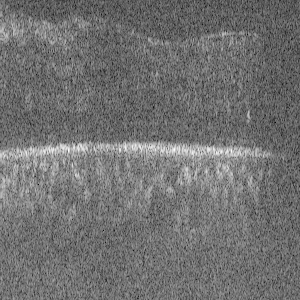

In [8]:
Noise = Image.open("./data/data2/RawDataQA-1-1 (141).tiff" , )
Noise

In [9]:
np.array(Noise).min() , np.array(Noise).max()

(0, 255)

In [10]:
tensor.cpu().numpy().shape

(3, 256, 256)

In [11]:
import numpy as np
Dnoise = np.array(Dnoise)

In [12]:
Dnoise.min() , Dnoise.max()

(0, 255)

In [13]:
tensor = Config.train_transform(image=Dnoise)["image"]
tensor , tensor.shape

(tensor([[[-0.9686, -0.8275, -0.9294,  ..., -0.9137, -0.9137, -0.9451],
          [-0.9529, -0.8353, -0.9294,  ..., -0.8902, -0.8745, -0.9373],
          [-0.9216, -0.8118, -0.8824,  ..., -0.8353, -0.8275, -0.8902],
          ...,
          [-0.9529, -1.0000, -0.9294,  ..., -0.9451, -0.9922, -0.9608],
          [-0.9686, -0.9843, -0.9373,  ..., -0.9373, -1.0000, -0.9765],
          [-0.9529, -0.9843, -0.9922,  ..., -0.9529, -1.0000, -0.9922]],
 
         [[ 4.0000, 22.0000,  9.0000,  ..., 11.0000, 11.0000,  7.0000],
          [ 6.0000, 21.0000,  9.0000,  ..., 14.0000, 16.0000,  8.0000],
          [10.0000, 24.0000, 15.0000,  ..., 21.0000, 22.0000, 14.0000],
          ...,
          [ 6.0000,  0.0000,  9.0000,  ...,  7.0000,  1.0000,  5.0000],
          [ 4.0000,  2.0000,  8.0000,  ...,  8.0000,  0.0000,  3.0000],
          [ 6.0000,  2.0000,  1.0000,  ...,  6.0000,  0.0000,  1.0000]],
 
         [[ 4.0000, 22.0000,  9.0000,  ..., 11.0000, 11.0000,  7.0000],
          [ 6.0000, 21.0000,

In [14]:
tensor.min() , tensor.max()

(tensor(-1.), tensor(254.))

In [15]:
tensor = tensor * 0.5 + 0.5

In [16]:
tensor.min() , tensor.max()

(tensor(0.), tensor(127.5000))